In [27]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle


image load funcation

In [28]:
def load_cifar10_dataset(dataset_dir):
    image_paths = []
    labels = []

    # Iterate through all files in the dataset directory
    for filename in os.listdir(dataset_dir):
    
        if filename.endswith(".png"):
    
            image_path = os.path.join(dataset_dir, filename)
    
            image_paths.append(image_path)

            # Extract label from filename
    
            if "_" in filename:
                label = int(filename.split("_")[-1].split(".")[0])
    
            else:
    
                # If no label is specified, assign label 0 (for airplanes)
                label = 0
    
            labels.append(label)

    images = []
    # Load images and convert to numpy array
    
    for image_path in image_paths:
    
        image = cv2.imread(image_path)
        # Convert BGR to RGB
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        images.append(image)

    
    return np.array(images), np.array(labels)


Dataset process

In [29]:
dataset_dir = "Dataset"

images, labels = load_cifar10_dataset(dataset_dir)


# Check the shape of the loaded images and labels

print("Shape of images array:", images.shape)

print("Length of labels array:", len(labels))

Shape of images array: (50000, 32, 32, 3)
Length of labels array: 50000


check image 

In [30]:
images[41]

array([[[ 54,  31,  18],
        [ 59,  34,  19],
        [ 56,  37,  22],
        ...,
        [133,  92,  53],
        [131,  89,  49],
        [132,  94,  53]],

       [[ 59,  38,  26],
        [ 62,  39,  26],
        [ 55,  36,  25],
        ...,
        [193, 135,  77],
        [200, 144,  86],
        [197, 142,  86]],

       [[ 41,  26,  18],
        [ 41,  25,  16],
        [ 36,  21,  13],
        ...,
        [202, 144,  84],
        [196, 141,  81],
        [190, 136,  79]],

       ...,

       [[105, 161, 157],
        [ 97, 163, 162],
        [ 96, 170, 164],
        ...,
        [ 98, 145, 144],
        [100, 138, 135],
        [100, 130, 123]],

       [[ 86, 149, 143],
        [ 96, 157, 156],
        [ 97, 164, 160],
        ...,
        [ 94, 127, 122],
        [ 98, 126, 120],
        [100, 124, 114]],

       [[ 70, 136, 128],
        [ 92, 146, 145],
        [113, 169, 168],
        ...,
        [ 98, 121, 111],
        [ 96, 117, 106],
        [ 92, 112, 101]]

preprocessing

In [31]:
def preprocess_images(images, resize_dim=(32, 32)):

    preprocessed_images = []

    for image in images:
        # Resize the image

        resized_image = cv2.resize(image, resize_dim)

        # Convert the image to grayscale

        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

        # Compute color histograms

        hist_r = cv2.calcHist([resized_image], [0], None, [256], [0, 256])

        hist_g = cv2.calcHist([resized_image], [1], None, [256], [0, 256])

        hist_b = cv2.calcHist([resized_image], [2], None, [256], [0, 256])


        # Concatenate histograms
        hist_features = np.concatenate((hist_r, hist_g, hist_b), axis=None)

        # Normalize the histograms
        hist_features /= np.sum(hist_features)

        # Concatenate the grayscale image and histogram features
        combined_features = np.concatenate((gray_image.flatten(), hist_features))

        preprocessed_images.append(combined_features)


    return np.array(preprocessed_images)



preprocess function call

In [32]:
preprocessed_images = preprocess_images(images)

# Check the shape of the preprocessed images

print("Shape of preprocessed images array:", preprocessed_images.shape)


Shape of preprocessed images array: (50000, 1792)


In [33]:
preprocessed_images[0]

array([2.0300000e+02, 2.0300000e+02, 2.0500000e+02, ..., 6.5104169e-04,
       3.2552084e-04, 0.0000000e+00], dtype=float32)

LSH class

In [34]:
class LSH:

    def __init__(self, num_tables, hash_size, num_projections):

        self.num_tables = num_tables

        self.hash_size = hash_size

        self.num_projections = num_projections

        self.tables = [{} for _ in range(num_tables)]

        self.projections = np.random.randn(num_projections, hash_size)


    def hash_vector(self, v):

        return ''.join(['1' if np.dot(v, p) > 0 else '0' for p in self.projections])

    def add_vector(self, v, label):

        for i in range(self.num_tables):

            hash_val = self.hash_vector(v)

            if hash_val not in self.tables[i]:

                self.tables[i][hash_val] = []

            self.tables[i][hash_val].append(label)


    def query(self, v):

        results = set()

        for i in range(self.num_tables):

            hash_val = self.hash_vector(v)

            if hash_val in self.tables[i]:


                results.update(self.tables[i][hash_val])

        return results


Query result

In [35]:
# Example usage

lsh = LSH(num_tables=10, hash_size=1792, num_projections=50)



# Assuming preprocessed_images is your feature vectors and labels is your array of labels

for idx, (feature_vector, label) in enumerate(zip(preprocessed_images, labels)):

    lsh.add_vector(feature_vector, label)



# Query a sample feature vector

query_index = 43

# test_queries = [1, 31, 43, 22, 11]


query_result = lsh.query(preprocessed_images[query_index])


print("Query result:", query_result)


Query result: {8, 3, 6}


check cosine similarity of top 5 

In [36]:
query_index = 43

query_vector = preprocessed_images[query_index]



# Get the labels of potential nearest neighbors using LSH

query_result = lsh.query(query_vector)



# Initialize a dictionary to store cosine similarities with corresponding indices

similarities = {}




# Iterate over the feature vectors corresponding to the labels returned by the LSH query

for idx, label in enumerate(labels):

    if label in query_result:

        # Compute cosine similarity between the query vector and the current vector

        similarity = cosine_similarity([query_vector], [preprocessed_images[idx]])[0][0]

        similarities[idx] = similarity



# Sort the dictionary by cosine similarity in descending order

sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)



# Get the indices of the top 5 similar vectors

top_5_similar_indices = [index for index, _ in sorted_similarities[:5]]



print("Top 5 similar vector indices:", top_5_similar_indices)

Top 5 similar vector indices: [43, 203, 20643, 41283, 19133]


Display funcation 

In [37]:
# Function to display images

def display_images(images, titles, num_cols=3):

    num_images = len(images)

    num_rows = (num_images + num_cols - 1) // num_cols



    plt.figure(figsize=(15, 5 * num_rows))




    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)


        plt.imshow(images[i])

        plt.title(titles[i])



        plt.axis('off')

    plt.show()


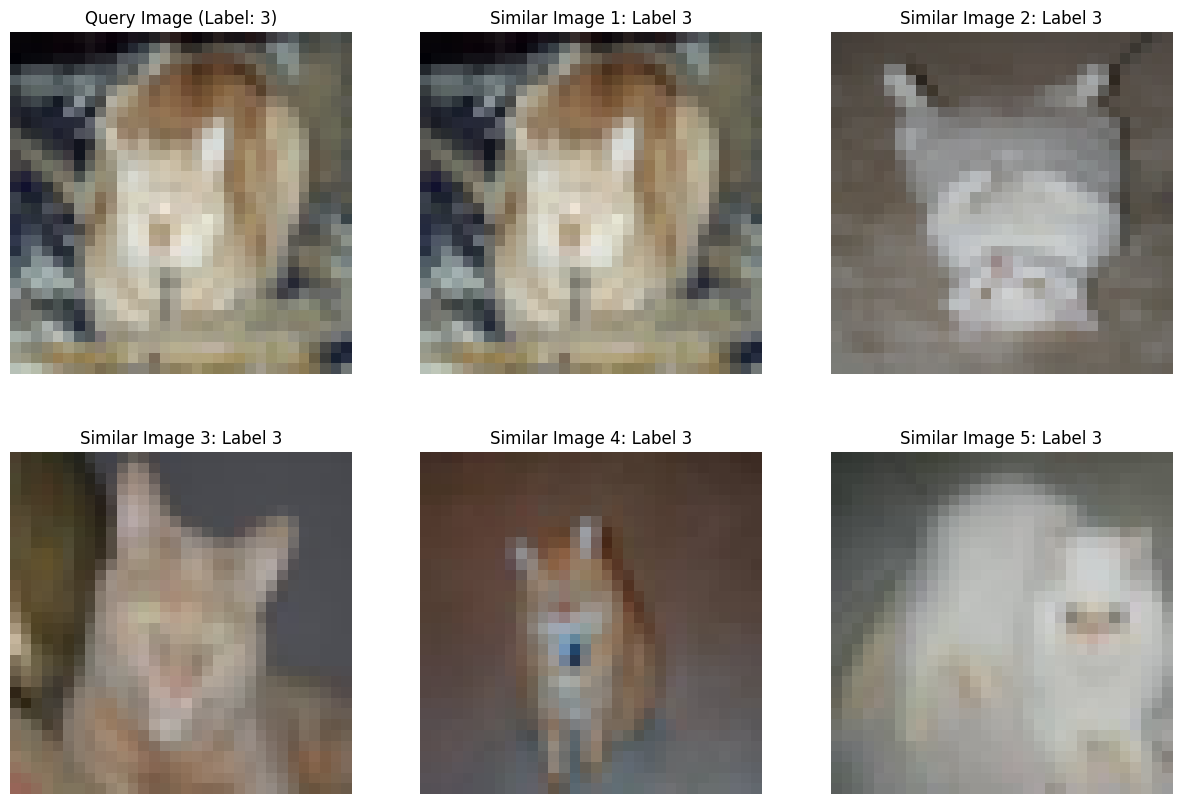

In [38]:
query_image = images[query_index]

query_title = "Query Image (Label: {})".format(labels[query_index])


# Load and display top 5 similar images

similar_images = [images[idx] for idx in top_5_similar_indices]

similar_titles = ["Similar Image {}: Label {}".format(i + 1, labels[idx]) for i, idx in enumerate(top_5_similar_indices)]

# Display query image and top 5 similar images

display_images([query_image] + similar_images, [query_title] + similar_titles)

Grouping of similar images 

In [39]:
import os
import cv2
import numpy as np

class LSH:

    def __init__(self, num_tables, hash_size, num_projections):

        self.num_tables = num_tables

        self.hash_size = hash_size

        self.num_projections = num_projections
        self.tables = [{} for _ in range(num_tables)]

        self.projections = np.random.randn(num_projections, hash_size)

    def hash_vector(self, v):
        return ''.join(['1' if np.dot(v, p) > 0 else '0' for p in self.projections])



    def add_vector(self, v, label):
        for i in range(self.num_tables):

            hash_val = self.hash_vector(v)

            if hash_val not in self.tables[i]:
                self.tables[i][hash_val] = []

            self.tables[i][hash_val].append(label)

    def query(self, v):

        results = set()

        for i in range(self.num_tables):
            hash_val = self.hash_vector(v)

            if hash_val in self.tables[i]:

                results.update(self.tables[i][hash_val])

        return results



def jaccard_similarity(set1, set2):

    intersection = len(set1.intersection(set2))

    union = len(set1.union(set2))

    return intersection / union if union != 0 else 0


# Example usage
lsh = LSH(num_tables=10, hash_size=1792, num_projections=50)

# Assuming preprocessed_images is your feature vectors and labels is your array of labels

for idx, (feature_vector, label) in enumerate(zip(preprocessed_images, labels)):
    lsh.add_vector(feature_vector, label)



# Query a sample feature vector

query_index = 43

query_vector = set(preprocessed_images[query_index])



# Get the labels of potential nearest neighbors using LSH

query_result = lsh.query(preprocessed_images[query_index])

# Specify a threshold for Jaccard similarity
jaccard_threshold = 0.5  # Adjust as needed



# Create folders to save similar images

save_dir = "Similar_Images"

os.makedirs(save_dir, exist_ok=True)


# Define the number of images to save in each group

images_per_group = 1000





# Initialize variables to track the number of images saved in each group

current_group_size = 0

current_group_folder = None


# Iterate over the feature vectors corresponding to the labels returned by the LSH query
for idx, label in enumerate(labels):

    if label in query_result:
        # Compute Jaccard similarity between the query set and the current set

        similarity = jaccard_similarity(query_vector, set(preprocessed_images[idx]))



        if similarity > jaccard_threshold:

            if current_group_size == 0 or current_group_size >= images_per_group:

                # Create a new folder for the group

                current_group_folder = os.path.join(save_dir, f"Group_{label}")

                os.makedirs(current_group_folder, exist_ok=True)

                current_group_size = 0

            # Save the similar image to the corresponding folder

            image_filename = f"similar_image_{idx}.png"

            image_path = os.path.join(current_group_folder, image_filename)

            cv2.imwrite(image_path, cv2.cvtColor(images[idx], cv2.COLOR_RGB2BGR))

            current_group_size += 1

# Print message indicating the completion of the process

print("Similar images saved in different folders.")


Similar images saved in different folders.
